# [Long Short Term Memory Networks using PyTorch](https://www.geeksforgeeks.org/long-short-term-memory-networks-using-pytorch/)

In [1]:
import sys
import os
from os import path
import importlib
import numpy as np

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

SRC_DIR = path.join(os.path.abspath(""), '../')
sys.path.append(SRC_DIR)

import core as co
from core import _
# importlib.reload(co)

``Orange trainY[0]`` is next to the blue sequence ``X_train[0]``. Blue balls are<br>single input to LSTM nn, orange one is the learning pattern.<br>

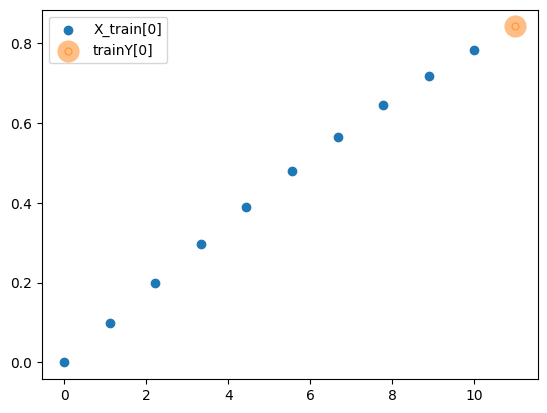

In [2]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic sine wave data
t = np.linspace(0, 100, 1000)
data = np.sin(t)

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length] # ``y`` is ``x[i + seq_length]``, next to the sequence ``x``
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)

# Convert data to PyTorch tensors
X_train = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

_("""``Orange trainY[0]`` is next to the blue sequence ``X_train[0]``. Blue balls are
single input to LSTM nn, orange one is the learning pattern.
""")
ynp = X_train[0].data.numpy()
xnp = np.linspace(0, len(ynp), len(ynp))
plt.scatter(xnp, ynp, label='X_train[0]')
plt.scatter([len(ynp) + 1], trainY[0].data.numpy(), label='trainY[0]', linewidths=10, alpha=0.5)
plt.legend()
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Model, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])  # Selecting the last output
        return out

In [4]:
num_epochs = 1000
accuracy = 1e-5
learning_rate = 0.001 #0.001 lr

input_size = 1
hidden_size = 100
output_size = 1
num_layers = 1

In [7]:
model = Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

loss0 = None
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    if loss0 is None:
        loss0 = loss.item()
    if loss.item() / loss0 < accuracy:
        break
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.1e}')

Model(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch [10/1000], Loss: 2.3e-01
Epoch [20/1000], Loss: 8.7e-02
Epoch [30/1000], Loss: 1.2e-02
Epoch [40/1000], Loss: 4.5e-03
Epoch [50/1000], Loss: 1.5e-03
Epoch [60/1000], Loss: 5.8e-04
Epoch [70/1000], Loss: 2.4e-04
Epoch [80/1000], Loss: 1.0e-04
Epoch [90/1000], Loss: 3.1e-05
Epoch [100/1000], Loss: 1.3e-05
Epoch [110/1000], Loss: 6.2e-06


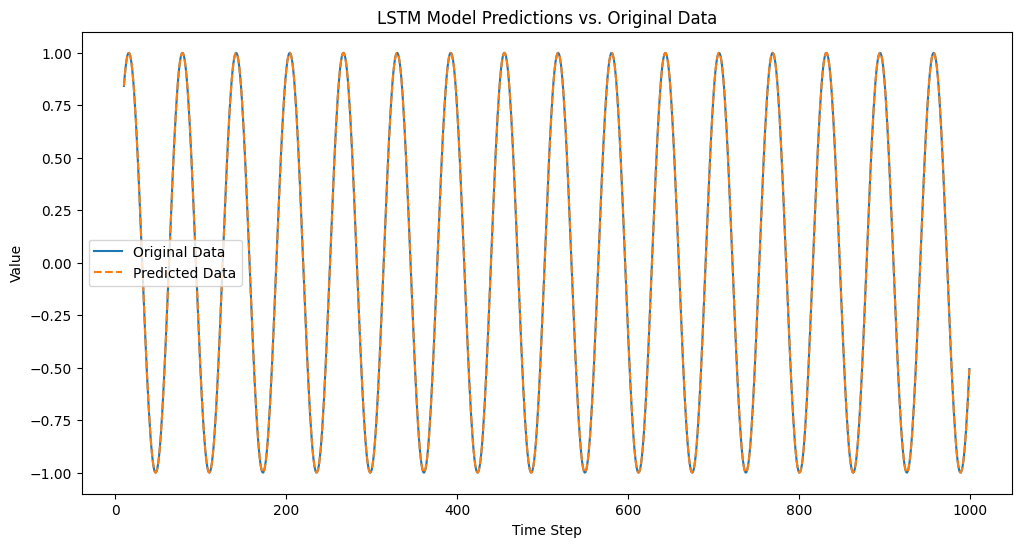

In [9]:
import matplotlib.pyplot as plt

# Predicted outputs
model.eval()
predicted = model(X_train).detach().numpy()

# Adjusting the original data and prediction for plotting
# The prediction corresponds to the point just after each sequence
original = data[seq_length:]  # Original data from the end of the first sequence
time_steps = np.arange(seq_length, len(data))  # Corresponding time steps

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()